<a href="https://colab.research.google.com/github/wendycao411/Pedestrian_Tracking/blob/main/Pedestrian_Tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pedestrian Tracking

created by wendycao 2025/1

best if run with T4 GPU (A100 GPU if Colab Pro)! it'll be much faster. to change GPU, go to the runtime tab and select "change runtime type".

#### When running in Google Colab:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Installing dependencies

In [1]:
%pip install opencv-python
%pip install pandas
%pip install numpy
%pip install ultralytics
%pip install roboflow
%pip install matplotlib
%pip install os-sys
%pip install roboflow
%pip install inference_sdk
%pip install easydict

%pip install lap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 913.6/913.6 kB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 46.2 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of os-sys to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions o

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 65.8 MB/s eta 0:00:00


In [2]:
%pip uninstall numpy -y
%pip install "numpy<1.24"

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 100.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.33.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
albumentations 1.4.20 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
albucore 0.0.19 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
blosc2 3.0.0 requires numpy>=1.25.0, but you have numpy 1.23.5 which is incompatible.
chex 0.1.88 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
jaxlib 0.4.33 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
pymc 5.19.1 requires numpy>=1.25.0, but you have numpy 1.23.5 which is incompatible.
xarray 2025.1.1 requi

In [1]:
import cv2
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from PIL import Image, ImageDraw
from inference_sdk import InferenceHTTPClient

from collections import defaultdict

from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator, colors

from roboflow import Roboflow

from IPython.display import Image, display

import torch

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

(if it asks to restart the runtime, click restart session and then re-run the cell importing modules)

#### Download Videos from Google Drive (requires the download link)

*How to generate the download link:*


1.   Get the "Share Link" for the video (make sure anyone can view the video!) - e.g. https://drive.google.com/file/d/1CNjE7CWTuyqgm-zTRGk5qIxSDG8A7P7q/view?usp=drive_link
2.   Get the ID for the video, which is in between the /d/ and /view - e.g. 1CNjE7CWTuyqgm-zTRGk5qIxSDG8A7P7q
3.   Paste the ID in this link: https://drive.google.com/uc?id=(ID HERE)&export=download -- e.g. https://drive.google.com/uc?id=1CNjE7CWTuyqgm-zTRGk5qIxSDG8A7P7q&export=download
4.   Done!



In [2]:
!gdown https://drive.google.com/uc?id=1MB2oEymBBnVrWViRzVVMLJE3vsOqdLYi&export=download

Downloading...
From (original): https://drive.google.com/uc?id=1MB2oEymBBnVrWViRzVVMLJE3vsOqdLYi
From (redirected): https://drive.google.com/uc?id=1MB2oEymBBnVrWViRzVVMLJE3vsOqdLYi&confirm=t&uuid=a00b020a-340a-48b1-ba08-bf04c9070beb
To: /content/2024-07-29 12_00.mp4
100% 2.56G/2.56G [00:43<00:00, 59.5MB/s]


#### Preprocessing

In [3]:
video_path = "/content/2024-07-29_12_00.mp4"
file_name = os.path.splitext(os.path.basename(video_path))[0]

print(file_name)

2024-07-29_12_00


In [5]:
# video preprocessing

# option 1 Adjust the frame rate to 5 FPS, and the total duration remains unchanged
!ffmpeg -i "/content/2024-07-29_12_00.mp4" -r 5 "/content/2024-07-29_12_00_5fps.mp4"


# NOT WORKING YET!!
# # option 2 function: subsample/time lapse video
# def subsample_video(input_path, output_path, time_lapse_interval):
#     cap = cv2.VideoCapture(input_path)
#     if not cap.isOpened():
#         print("Error: Couldn't open video file.")
#         return

#     frame_count = 0
#     fps = cap.get(cv2.CAP_PROP_FPS)
#     width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
#     height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
#     codec = cv2.VideoWriter_fourcc(*'XVID')
#     out = cv2.VideoWriter(output_path, codec, fps, (width, height))

#     while cap.isOpened():
#         ret, frame = cap.read()
#         if not ret:
#             break

#         # Collect one frame out of every xx frames
#         if frame_count % time_lapse_interval == 0:
#             out.write(frame)

#         frame_count += 1

#     cap.release()
#     out.release()
#     #cv2.destroyAllWindows()

# if __name__ == "__main__":
#     time_lapse_interval = 5 # change here
#     input_file = video_path
#     output_file = f"/content/Pedestrian_Tracking/timelapsed/{file_name}_timelapsed{time_lapse_interval}.mp4"  # Replace with desired output video file path
#     subsample_video(input_file, output_file, time_lapse_interval)
#     print(f"saved to {output_file}")

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [6]:
video_path = "/content/2024-07-29_12_00_5fps.mp4"
file_name = os.path.splitext(os.path.basename(video_path))[0]

print(video_path)
print(file_name)

/content/2024-07-29_12_00_5fps.mp4
2024-07-29_12_00_5fps


In [7]:
# number of frames in the video
cap = cv2.VideoCapture(video_path)

# Get the file name
file_name = os.path.splitext(os.path.basename(video_path))[0]

# Get the total number of frames of the video
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
original_fps = cap.get(cv2.CAP_PROP_FPS)

print(f"The total number of frames in the video：{total_frames}\nVideo frame rate：{original_fps}")
cap.release()

The total number of frames in the video：5167
Video frame rate：5.0


#### Download the Model!

can also download elsewhere and upload to get other models and test if they are better

In [8]:
!gdown https://drive.google.com/uc?id=19ZYplT-m0SaXrJXks9DhO7wdIUMpK2_F&export=download

#used by Emma, not tested if more accurate yet
#!gdown https://drive.google.com/uc?id=1WFUfBKAB2_U96PwHiI08seJzKk3yeGLg&export=download

Downloading...
From (original): https://drive.google.com/uc?id=19ZYplT-m0SaXrJXks9DhO7wdIUMpK2_F
From (redirected): https://drive.google.com/uc?id=19ZYplT-m0SaXrJXks9DhO7wdIUMpK2_F&confirm=t&uuid=33c3f423-d696-49ba-81d1-7d64edb866e4
To: /content/yolov8x-seg.pt
100% 144M/144M [00:04<00:00, 34.9MB/s]


#### To implement the DeepSORT tracking, downloading the required files (only needs to be done once at the beginnning of running the code)

In [9]:
!gdown "https://drive.google.com/uc?id=11ZSZcG-bcbueXZC3rN08CM0qqX3eiHxf&confirm=t"

Downloading...
From: https://drive.google.com/uc?id=11ZSZcG-bcbueXZC3rN08CM0qqX3eiHxf&confirm=t
To: /content/deep_sort_pytorch.zip
100% 43.1M/43.1M [00:00<00:00, 66.7MB/s]


In [10]:
!unzip 'deep_sort_pytorch.zip'

Archive:  deep_sort_pytorch.zip
  inflating: deep_sort_pytorch/.gitignore  
   creating: deep_sort_pytorch/configs/
  inflating: deep_sort_pytorch/configs/deep_sort.yaml  
   creating: deep_sort_pytorch/deep_sort/
  inflating: deep_sort_pytorch/deep_sort/__init__.py  
   creating: deep_sort_pytorch/deep_sort/__pycache__/
  inflating: deep_sort_pytorch/deep_sort/__pycache__/__init__.cpython-310.pyc  
  inflating: deep_sort_pytorch/deep_sort/__pycache__/__init__.cpython-37.pyc  
  inflating: deep_sort_pytorch/deep_sort/__pycache__/__init__.cpython-38.pyc  
  inflating: deep_sort_pytorch/deep_sort/__pycache__/deep_sort.cpython-310.pyc  
  inflating: deep_sort_pytorch/deep_sort/__pycache__/deep_sort.cpython-37.pyc  
  inflating: deep_sort_pytorch/deep_sort/__pycache__/deep_sort.cpython-38.pyc  
   creating: deep_sort_pytorch/deep_sort/deep/
 extracting: deep_sort_pytorch/deep_sort/deep/__init__.py  
   creating: deep_sort_pytorch/deep_sort/deep/__pycache__/
  inflating: deep_sort_pytorch/d

#### Run the Script for Segmentation with DeepSORT Tracking

In [11]:
from deep_sort_pytorch.utils.parser import get_config
from deep_sort_pytorch.deep_sort import DeepSort
from collections import deque

In [12]:
# Set parameters
skip = 2
output_dir = "output"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

output_video_path = os.path.join(output_dir, f"{file_name}_human-and-shade-tracking.avi")
csv_file = os.path.join(output_dir, f"{file_name}_detections.csv")

# Initialize Roboflow client for shadow detection
CLIENT = InferenceHTTPClient(api_url="https://detect.roboflow.com", api_key="10y4aLdke807CNnG81Dm")

# Load the YOLO model for person detection
model_person = YOLO("/content/yolov8x-seg.pt").to("cuda")  # Ensure this is your correct device

# Initialize the DeepSORT tracker
def init_tracker():
    cfg = get_config()
    cfg.merge_from_file("deep_sort_pytorch/configs/deep_sort.yaml")

    deepsort = DeepSort(cfg.DEEPSORT.REID_CKPT,
                        max_dist=cfg.DEEPSORT.MAX_DIST,
                        min_confidence=cfg.DEEPSORT.MIN_CONFIDENCE,
                        nms_max_overlap=cfg.DEEPSORT.NMS_MAX_OVERLAP,
                        max_iou_distance=cfg.DEEPSORT.MAX_IOU_DISTANCE,
                        max_age=cfg.DEEPSORT.MAX_AGE,
                        n_init=cfg.DEEPSORT.N_INIT,
                        nn_budget=cfg.DEEPSORT.NN_BUDGET,
                        use_cuda=True)
    return deepsort

deepsort = init_tracker()

# Dictionary to store trails
trails = {}

# Open the video file
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

w, h, fps = (int(cap.get(x)) for x in (cv2.CAP_PROP_FRAME_WIDTH, cv2.CAP_PROP_FRAME_HEIGHT, cv2.CAP_PROP_FPS))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  # Get total frame count
out = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*"MJPG"), fps, (w, h))

# Initialize CSV file
csv_headers = ['frame', 'person_id', 'bottom_mid_x', 'bottom_mid_y', 'in_shadow']
with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(csv_headers)

frame_count = 0

while cap.isOpened():
    success, frame = cap.read()
    if not success:
        print("Video frame is empty or video processing has been successfully completed.")
        break

    frame_count += 1

    if frame_count % skip == 0:
        print(f"Processing frame {frame_count}/{total_frames}")  # Display progress

        # Get the shadow boundary of the current frame
        shadow_result = CLIENT.infer(frame, model_id="shade-detection/1")
        boundaries = []

        if 'predictions' in shadow_result:
            predictions = shadow_result['predictions']
            for prediction in predictions:
                points = prediction.get("points", [])
                if points:
                    boundary = [(int(point['x']), int(point['y'])) for point in points]
                    boundaries.append(boundary)

        annotator = Annotator(frame, line_width=2)
        people_in_shadow = 0
        people_outside_shadow = 0
        total_people = 0
        detections = []

        # Draw the shadow polygon
        for boundary in boundaries:
            boundary_points = np.array(boundary, np.int32).reshape((-1, 1, 2))
            cv2.polylines(frame, [boundary_points], isClosed=True, color=(255, 0, 0), thickness=2)

        # People detection
        person_results = model_person(frame, classes=[0], conf=0.05, show=False)
        if person_results and len(person_results) > 0:
            boxes = person_results[0].boxes

            if boxes and len(boxes) > 0:
                xyxy = boxes.xyxy.cpu().numpy()
                confidences = boxes.conf.cpu().numpy()
                oids = boxes.cls.cpu().numpy()

                # Convert to the format expected by DeepSORT
                bbox_xywh = []
                for box in xyxy:
                    x1, y1, x2, y2 = box
                    xc = (x1 + x2) / 2
                    yc = (y1 + y2) / 2
                    w = x2 - x1
                    h = y2 - y1
                    bbox_xywh.append([xc, yc, w, h])

                bbox_xywh = np.array(bbox_xywh)

                # Update DeepSORT tracker with detected boxes
                outputs = deepsort.update(bbox_xywh, confidences, oids, frame)

                for output in outputs:
                    x1, y1, x2, y2, track_id, track_oid = output
                    bottom_mid_x = int((x1 + x2) // 2)
                    bottom_mid_y = int(y2)
                    in_shadow = False

                    for boundary in boundaries:
                        if cv2.pointPolygonTest(np.array(boundary, np.int32), (bottom_mid_x, bottom_mid_y), False) >= 0:
                            in_shadow = True
                            people_in_shadow += 1
                            break
                    else:
                        people_outside_shadow += 1

                    detections.append([frame_count, track_id, bottom_mid_x, bottom_mid_y, in_shadow])
                    total_people += 1

                    # Store the position for trails
                    if track_id not in trails:
                        trails[track_id] = deque(maxlen=30)
                    trails[track_id].append((bottom_mid_x, bottom_mid_y))

                    # Draw the trails
                    for i in range(1, len(trails[track_id])):
                        if trails[track_id][i - 1] is None or trails[track_id][i] is None:
                            continue
                        cv2.line(frame, trails[track_id][i - 1], trails[track_id][i], (0, 255, 0), 2)

                    color = (0, 255, 0)  # You can use your colors function if defined
                    label = f"ID {track_id} {'in shadow' if in_shadow else 'out shadow'}"
                    annotator.box_label([x1, y1, x2, y2], label=label, color=color)
                    cv2.circle(frame, (bottom_mid_x, bottom_mid_y), 5, (0, 0, 255), -1)

        # Write the results to CSV
        with open(csv_file, 'a', newline='') as file:
            writer = csv.writer(file)
            writer.writerows(detections)

        # Display the statistics results on the frame
        text = f"Frame {frame_count}: Total: {total_people}, In Shadow: {people_in_shadow}, Outside Shadow: {people_outside_shadow}"
        cv2.putText(frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

        # Write the original frame
        out.write(frame)

        # Write the duplicated frame
        out.write(frame)

        #COMMENT OUT IF ON COLAB, but can display progress
        #cv2_imshow("instance-segmentation-object-tracking", frame)  # Display the frame using cv2_imshow
        #if cv2.waitKey(1) & 0xFF == ord("q"):
        #    break

cap.release()
out.release()

print(f"Processing complete. Results saved in {output_video_path} and {csv_file}.")

Streaming output truncated to the last 5000 lines.
0: 384x640 9 persons, 13.7ms
Speed: 2.4ms preprocess, 13.7ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)
Processing frame 2670/5167

0: 384x640 10 persons, 15.2ms
Speed: 3.0ms preprocess, 15.2ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)
Processing frame 2672/5167

0: 384x640 10 persons, 13.4ms
Speed: 2.2ms preprocess, 13.4ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)
Processing frame 2674/5167

0: 384x640 4 persons, 13.0ms
Speed: 2.5ms preprocess, 13.0ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)
Processing frame 2676/5167

0: 384x640 8 persons, 13.6ms
Speed: 2.3ms preprocess, 13.6ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)
Processing frame 2678/5167

0: 384x640 7 persons, 13.6ms
Speed: 2.3ms preprocess, 13.6ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)
Processing frame 2680/5167

0: 384x640 5 persons, 1

# Data Analysis

      Frame  in_shadow  out_shadow
0         0          0           0
1         1          0           0
2         2          0           0
3         3          0           0
4         4          0           0
...     ...        ...         ...
2566   2566          5           5
2567   2567          0           0
2568   2568          5           5
2569   2569          0           0
2570   2570          5           4

[2571 rows x 3 columns]


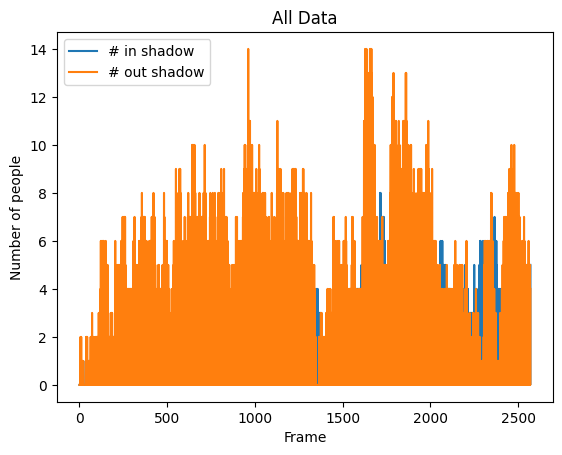

In [13]:
import pandas as pd

data = pd.read_csv(csv_file)
num_in_shadow = {}
num_out_shadow = {}

for i in range(data['frame'].nunique()):
  count = len(data[(data['in_shadow'] == True) & (data['frame'] == i)])
  num_in_shadow[i] = count
  count = len(data[(data['in_shadow'] == False) & (data['frame'] == i)])
  num_out_shadow[i] = count

df = pd.DataFrame([num_in_shadow, num_out_shadow]).T
df.columns = ['in_shadow', 'out_shadow']
df.reset_index(inplace=True)

# Optional: Rename the index column
df.rename(columns={'index': 'Frame'}, inplace=True)

print(df)

fig, ax = plt.subplots()
ax.plot(df['Frame'], df['in_shadow'], label='# in shadow')
ax.plot(df['Frame'], df['out_shadow'], label='# out shadow')
ax.legend()

ax.set_xlabel('Frame')
ax.set_ylabel('Number of people')
plt.title("All Data")

plt.show()

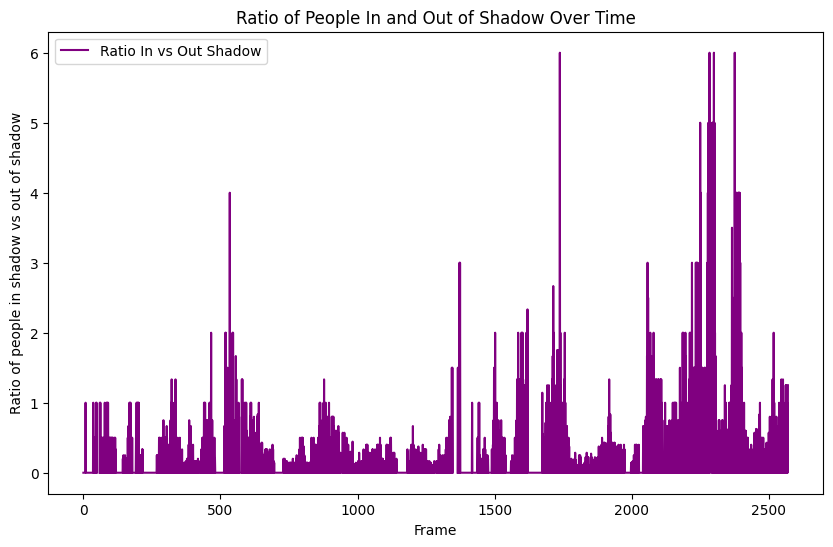

In [18]:
# Calculate the ratio of people in shade vs. out of shade
df['ratio_in_vs_out'] = df['in_shadow'] / df['out_shadow']

# Replace NaN values with zeros (or another value if appropriate)
df['ratio_in_vs_out'] = df['ratio_in_vs_out'].fillna(0)

# Plot the ratio
plt.figure(figsize=(10, 6))
plt.plot(df['Frame'], df['ratio_in_vs_out'], label='Ratio In vs Out Shadow', color='purple')
plt.xlabel('Frame')
plt.ylabel('Ratio of people in shadow vs out of shadow')
plt.title('Ratio of People In and Out of Shadow Over Time')
plt.legend()
plt.show()

#### Moving Average

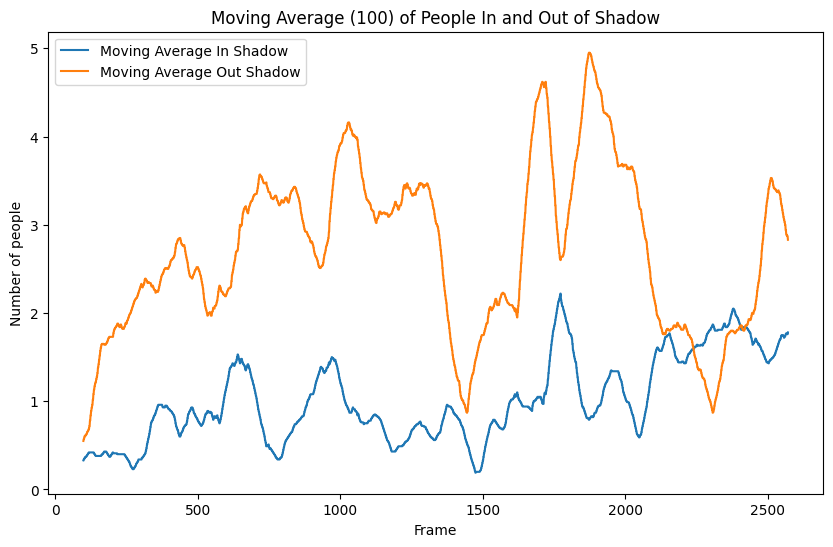

In [14]:
# Calculate the moving average for 'out_shadow'
#edit window
df['ma_out_shadow'] = df['out_shadow'].rolling(window=100).mean()

df['ma_in_shadow'] = df['in_shadow'].rolling(window=100).mean()

# Plot the moving averages
plt.figure(figsize=(10, 6))
plt.plot(df['Frame'], df['ma_in_shadow'], label='Moving Average In Shadow')
plt.plot(df['Frame'], df['ma_out_shadow'], label='Moving Average Out Shadow')
plt.legend()
plt.xlabel('Frame')
plt.ylabel('Number of people')
plt.title('Moving Average (100) of People In and Out of Shadow')
plt.show()

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




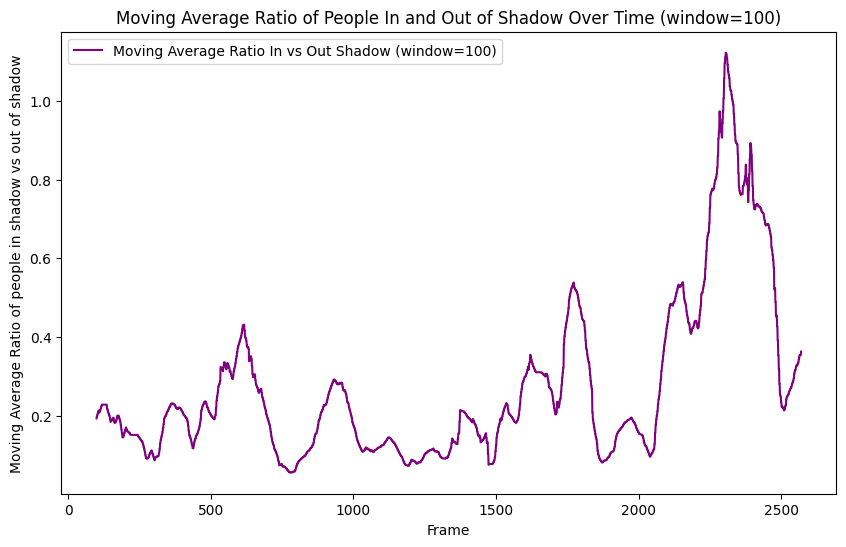

In [20]:
# Calculate the ratio of people in shade vs. out of shade
df['ratio_in_vs_out'] = df['in_shadow'] / df['out_shadow']

# Replace NaN and infinite values with zeros (or another value if appropriate)
df['ratio_in_vs_out'].replace([np.inf, -np.inf], np.nan, inplace=True)
df['ratio_in_vs_out'] = df['ratio_in_vs_out'].fillna(0)

# Calculate the moving average for the ratio
window_size = 100
df['ma_ratio_in_vs_out'] = df['ratio_in_vs_out'].rolling(window=window_size).mean()

# Plot the moving average of the ratio
plt.figure(figsize=(10, 6))
plt.plot(df['Frame'], df['ma_ratio_in_vs_out'], label=f'Moving Average Ratio In vs Out Shadow (window={window_size})', color='purple')
plt.xlabel('Frame')
plt.ylabel('Moving Average Ratio of people in shadow vs out of shadow')
plt.title(f'Moving Average Ratio of People In and Out of Shadow Over Time (window={window_size})')
plt.legend()
plt.show()

#### Group coordinates for each ID

In [21]:
# Load the CSV data
data = pd.read_csv(csv_file)

# Group data by person_id and aggregate coordinates and in_shadow status into a list of tuples
grouped_data = data.groupby('person_id').apply(lambda x: list(zip(x['bottom_mid_x'], x['bottom_mid_y'], x['in_shadow']))).reset_index()
grouped_data.columns = ['person_id', 'coordinates_and_shadow']

# Display the grouped data
print(grouped_data)

     person_id                             coordinates_and_shadow
0            1  [(1716, 595, False), (1721, 590, False), (1728...
1            2  [(1757, 605, False), (1763, 598, True), (1766,...
2           11  [(1783, 704, True), (1781, 707, True), (1780, ...
3           24  [(1434, 784, False), (1466, 767, False), (1491...
4           45  [(855, 828, False), (895, 799, False), (934, 7...
..         ...                                                ...
344       1895  [(1724, 1074, False), (1730, 1073, False), (17...
345       1897  [(1795, 674, True), (1799, 678, True), (1799, ...
346       1899  [(1674, 627, True), (1665, 637, True), (1660, ...
347       1906  [(1666, 650, True), (1656, 659, True), (1643, ...
348       1910  [(1699, 673, True), (1688, 683, True), (1680, ...

[349 rows x 2 columns]


DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


#### Scatter Plot

In [22]:
! pip install seaborn

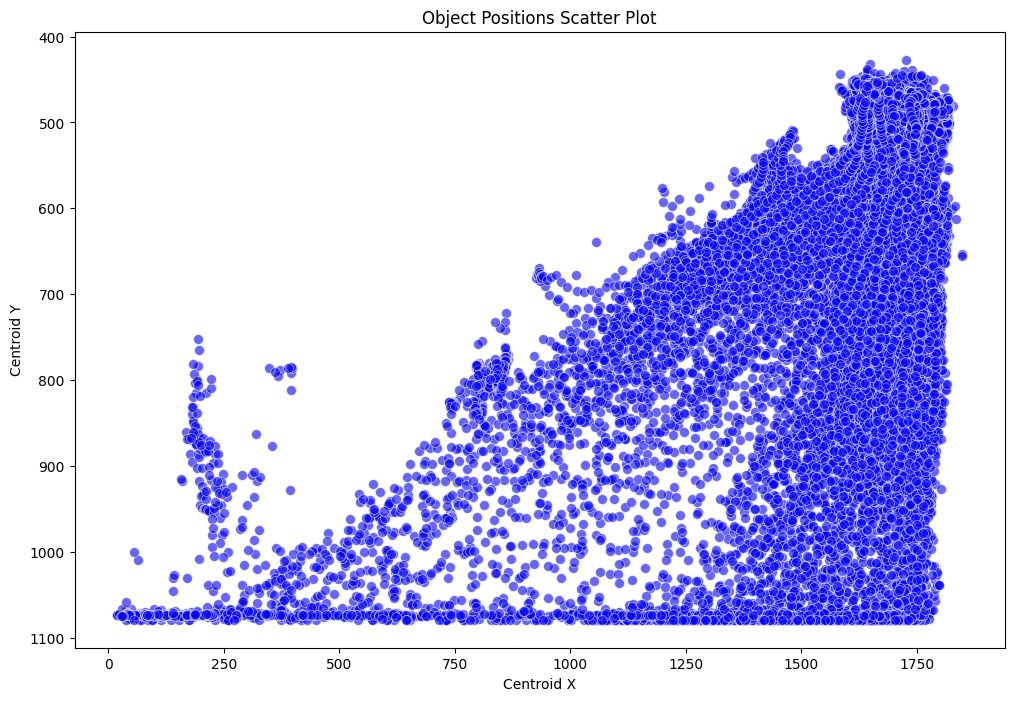

In [23]:
import seaborn as sns

# Load the CSV data into a DataFrame
data = pd.read_csv(csv_file)  # Ensure your file name is correct

# Create a scatter plot of object positions
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='bottom_mid_x',
    y='bottom_mid_y',
    data=data,
    s=50,  # Adjust the size of the dots
    alpha=0.6,  # Adjust the transparency of the dots
    color='blue'
)
plt.gca().invert_yaxis()
plt.title('Object Positions Scatter Plot')
plt.xlabel('Centroid X')
plt.ylabel('Centroid Y')
plt.show()


#### Paths Plot

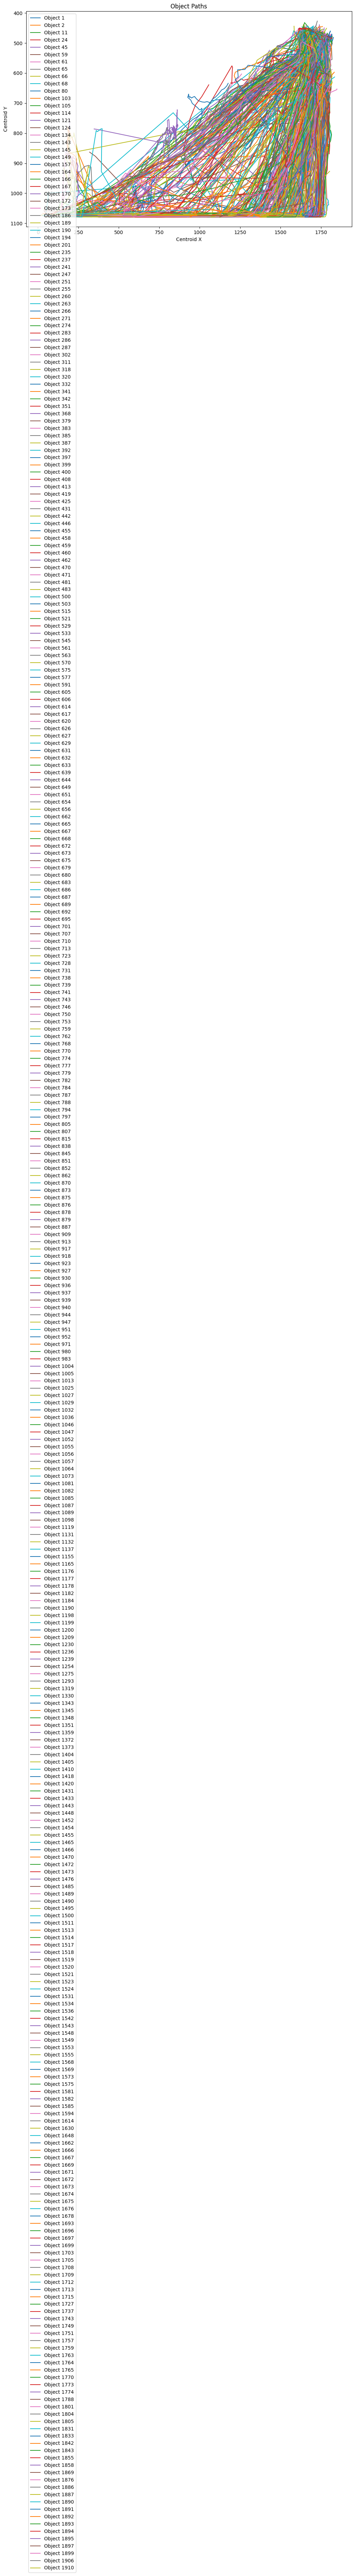

In [24]:
# Group data by object ID
grouped_data = data.groupby('person_id')

plt.figure(figsize=(12, 8))
for object_id, group in grouped_data:
    plt.plot(group['bottom_mid_x'], group['bottom_mid_y'], label=f'Object {object_id}')
plt.gca().invert_yaxis()
plt.xlabel('Centroid X')
plt.ylabel('Centroid Y')
plt.title('Object Paths')
plt.legend()
plt.show()

#### (WIP) Object Density Heatmap Evolution

In [29]:
import pandas as pd

csv_file = "/content/output/2024-07-29_12_00_5fps_detections.csv"

# Load the CSV data
data = pd.read_csv(csv_file)

# Group data by frame number for a dynamic heatmap
unique_frames = data['frame'].unique()

# Define the name of the video and create a directory with the same name
video_name = 'heatmap_evolution'
os.makedirs(video_name, exist_ok=True)

# Loop through each frame and create a heatmap
for frame in unique_frames:
    # Filter data for the current frame
    frame_data = data[data['frame'] == frame]

    # Create the heatmap
    plt.figure(figsize=(12, 8))
    sns.kdeplot(
        x=frame_data['bottom_mid_x'],
        y=frame_data['bottom_mid_y'],
        fill=True,
        cmap='viridis',
        warn_singular=False
    )

    plt.gca().invert_yaxis()
    # Set plot title and labels
    plt.title(f'Heatmap for Frame {frame}')
    plt.xlabel('Centroid X')
    plt.ylabel('Centroid Y')

    # Save the heatmap image
    plt.savefig(f'/content/heatmap_evolution/heatmap_{frame:04d}.png')
    plt.close()

os.system(f'ffmpeg -r 30 -i {video_name}/heatmap_%04d.png')

256

In [30]:
!ffmpeg -pattern_type glob -framerate 1 -i '/content/heatmap_evolution/heatmap_*.png' -c:v libx264 -r 30 -pix_fmt yuv420p 'output.mp4'

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab